In [132]:
## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__) 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import math # Mathematical functions 


2.2.0


In [133]:
data =  pd.read_csv('./dataset/bitcoin/bitcoin_10min_dataset.csv', header=0)

In [134]:
data.head()

,Date,Open,High,Low,Close,SMAVG_50d,SMAVG_100d,SMAVG_200d
0,12/19/2022 11:00,16770.05,16775.00,16763.77,16763.77,16728.81,16749.16,16737.91
1,12/19/2022 10:50,16772.25,16777.00,16766.13,16770.90,16728.47,16749.18,16737.72
2,12/19/2022 10:40,16772.46,16779.30,16766.43,16772.25,16727.77,16749.38,16737.47
3,12/19/2022 10:30,16771.48,16778.55,16764.63,16772.46,16727.55,16749.23,16737.19
4,12/19/2022 10:20,16771.50,16780.25,16767.98,16771.48,16727.44,16748.67,16737.00


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Date        100000 non-null  object 
 1   Open        100000 non-null  float64
 2   High        100000 non-null  float64
 3   Low         100000 non-null  float64
 4   Close       100000 non-null  float64
 5   SMAVG_50d   100000 non-null  float64
 6   SMAVG_100d  100000 non-null  float64
 7   SMAVG_200d  100000 non-null  float64
dtypes: float64(7), object(1)
memory usage: 6.1+ MB


In [136]:
data['Date'] = pd.to_datetime(data['Date'])


In [137]:
data=data.sort_values(by="Date", ascending=True)
data.set_index("Date",inplace=True)

In [138]:

data=data[(data.index >= '2022-04-01') & (data.index <= '2022-09-30')]

In [139]:
data.head()

,Open,High,Low,Close,SMAVG_50d,SMAVG_100d,SMAVG_200d
Date,,,,,,,
2022-04-01 00:00:00,45807.09,45808.32,45677.81,45680.84,45916.09,46526.95,46847.68
2022-04-01 00:10:00,45680.63,45714.11,45638.63,45665.02,45895.07,46512.44,46840.99
2022-04-01 00:20:00,45665.07,45705.22,45633.79,45696.46,45876.87,46497.72,46834.89
2022-04-01 00:30:00,45696.46,45731.87,45658.29,45667.18,45858.10,46482.98,46827.55
2022-04-01 00:40:00,45669.05,45688.13,45231.34,45411.71,45835.46,46465.93,46818.93


### Select Features

In [140]:
data_prices = data.drop(['SMAVG_100d','High','Low'], axis=1)

In [141]:
data_prices

,Open,Close,SMAVG_50d,SMAVG_200d
Date,,,,
2022-04-01 00:00:00,45807.09,45680.84,45916.09,46847.68
2022-04-01 00:10:00,45680.63,45665.02,45895.07,46840.99
2022-04-01 00:20:00,45665.07,45696.46,45876.87,46834.89
2022-04-01 00:30:00,45696.46,45667.18,45858.10,46827.55
2022-04-01 00:40:00,45669.05,45411.71,45835.46,46818.93
...,...,...,...,...
2022-09-29 23:20:00,19521.02,19462.57,19354.10,19413.19
2022-09-29 23:30:00,19462.29,19452.66,19365.23,19414.81
2022-09-29 23:40:00,19452.68,19427.41,19374.05,19416.21


In [142]:
# We add a prediction column and set dummy values to prepare the data for scaling
data_prices_ext = data_prices.copy()
data_prices_ext['Prediction'] = data_prices_ext['Close']

# Print the tail of the dataframe
data_prices_ext.tail()

,Open,Close,SMAVG_50d,SMAVG_200d,Prediction
Date,,,,,
2022-09-29 23:20:00,19521.02,19462.57,19354.10,19413.19,19462.57
2022-09-29 23:30:00,19462.29,19452.66,19365.23,19414.81,19452.66
2022-09-29 23:40:00,19452.68,19427.41,19374.05,19416.21,19427.41
2022-09-29 23:50:00,19427.41,19460.94,19382.94,19418.09,19460.94
2022-09-30 00:00:00,19463.22,19459.86,19388.82,19419.60,19459.86


## Scaling the Multivariate Input Data

In [143]:
# Get the number of rows in the data
nrows = data_prices.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_prices)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_prices_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(26209, 4)


In [144]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 6

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(20962, 6, 4) (20962,)
(5241, 6, 4) (5241,)
0.9983880053578168
0.9983880053578168


### Train LSTM Model


In [145]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 6, 16)             1344      
_________________________________________________________________
dropout_40 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dropout_41 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_________________________________________________________________


In [146]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
230/230 [==============================] - 4s 18ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 1.1434e-04 - val_root_mean_squared_error: 0.0107
Epoch 2/40
230/230 [==============================] - 4s 15ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 7.6375e-05 - val_root_mean_squared_error: 0.0087
Epoch 3/40
230/230 [==============================] - 3s 14ms/step - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 8.7677e-05 - val_root_mean_squared_error: 0.0094
Epoch 4/40
230/230 [==============================] - 3s 15ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 3.6585e-05 - val_root_mean_squared_error: 0.0060
Epoch 5/40
230/230 [==============================] - 4s 16ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 4.0036e-05 - val_root_mean_squared_error: 0.0063
Epoch 6/40
230/230 [==============================] - 4s 16ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565

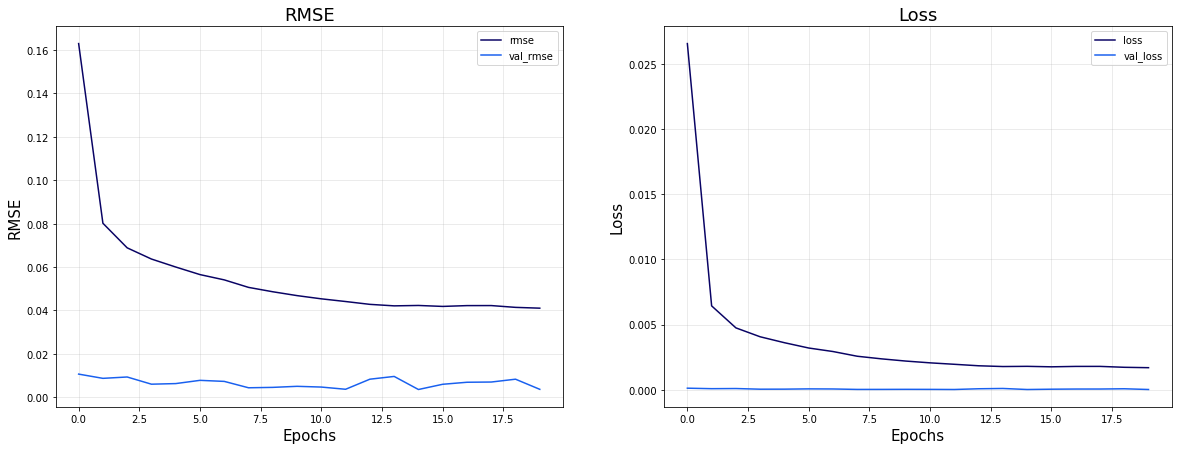

In [147]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [148]:
results = regressor.evaluate(x_test, y_test)
print("test loss, test acc:", np.round(results, 4))

164/164 [==============================] - 0s 2ms/step - loss: 7.8221e-05 - root_mean_squared_error: 0.0088
test loss, test acc: [0.0001 0.0088]


### Hyperparameter Tunning

In [149]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 0.00004, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00004 to 0.00002, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.00002 to 0.00001, saving model to best_model.h5

Epoch 00004: val_loss did not improve from 0.00001

Epoch 00005: val_loss improved from 0.00001 to 0.00001, saving model to best_model.h5

Epoch 00006: val_loss did not improve from 0.00001

Epoch 00007: val_loss did not improve from 0.00001

Epoch 00008: val_loss improved from 0.00001 to 0.00001, saving model to best_model.h5

Epoch 00009: val_loss did not improve from 0.00001

Epoch 00010: val_loss did not improve from 0.00001

Epo

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

In [ ]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

In [ ]:
results=regressor.evaluate(x_test, y_test)
print("test loss, test acc:", np.round(results, 4))

In [ ]:
y_pred_scaled = regressor.predict(x_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred_scaled, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')

In [ ]:
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_actual

In [ ]:
display_start_date = "2022-04-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_prices_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_prices_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

In [ ]:
# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

In [ ]:
df_union_zoom

In [ ]:
# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("Bitcoin", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')